# CNN KMNIST

##Libraries and data

In [ ]:
import tensorflow as tf
print(tf.__version__)

import numpy as np
print(np.__version__)

import matplotlib
import matplotlib.pyplot as plt
print(matplotlib.__version__)

2.17.0
1.26.4
3.7.1


Check whether a GPU is present:

In [ ]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    print('GPU device not found')
else:
    print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


If you obtain `GPU device not found`, try  
> Runtime > Change runtime type >  GPU  

and run again.

### Dataset upload



In [ ]:
import numpy as np

x_train = np.load('kmnist-train-imgs.npz')['arr_0']
y_train = np.load('kmnist-train-labels.npz')['arr_0']
x_test = np.load('kmnist-test-imgs.npz')['arr_0']
y_test = np.load('kmnist-test-labels.npz')['arr_0']

#Now the arrays are 60.000 images 28x28. We want it to be 60.000 x 784.

#x_train = X_train.reshape(X_train.shape[0], -1)
#x_test = X_test.reshape(X_test.shape[0], -1)

#Xtrain = np.file("kminst-train-imgs.npz")
#Ytrain = np.file("kmnist-train-labels.npz")
#Xtest = "kmnist-test-imgs.npz"
#Ytest = "kmnist-test-labels.npz"

#print(X_train.shape, X_test.shape)
print(x_train.shape,y_train.shape)
print(x_test.shape, y_test.shape)

(60000, 28, 28) (60000,)
(10000, 28, 28) (10000,)


Define a human-readable description of labels:

In [ ]:
# Define the text labels
k_mnist_labels = ["O",  # index 0
                        "KI",      # index 1
                        "SU",     # index 2
                        "TSU",        # index 3
                        "NA",         # index 4
                        "HA",       # index 5
                        "MA",        # index 6
                        "YA",      # index 7
                        "RE",          # index 8
                        "WO"]   # index 9

### Visualize images
Select an image index in the cell below and repeat execution:

Image 256 (label 5: HA)


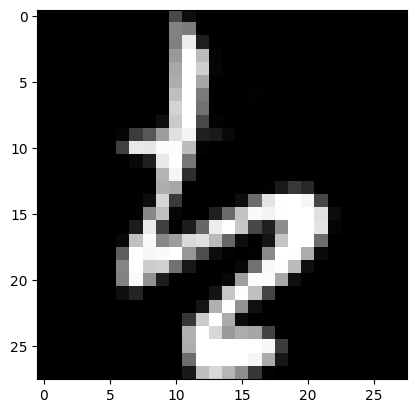

In [ ]:
# Image index: pick any number between 0 and 59999
img_index = 256
label_index = y_train[img_index]

print("Image {} (label {}: {})".format(img_index, label_index, k_mnist_labels[label_index]))
# Show one of the images from the training dataset
plt.imshow(x_train[img_index], cmap='gray')

### Data preparation

Normalize images (do NOT flatten them):

In [ ]:
# Normalize pixel values
x_train_prep, x_test_prep = x_train/255., x_test/255.

print()
print("x_train_prep is of type {} with shape {} and dtype {}".format(type(x_train_prep), x_train_prep.shape, x_train_prep.dtype))
print("x_test_prep is of type {} with shape {} and dtype {}".format(type(x_test_prep), x_test_prep.shape, x_test_prep.dtype))


x_train_prep is of type <class 'numpy.ndarray'> with shape (60000, 28, 28) and dtype float64
x_test_prep is of type <class 'numpy.ndarray'> with shape (10000, 28, 28) and dtype float64


Split train dataset into *train* and *validation* slices, using the first 5000 images for validation:

In [ ]:
(x_train_prep, x_valid_prep) = x_train_prep[5000:], x_train_prep[:5000]
(y_train, y_valid) = y_train[5000:], y_train[:5000]

print()
print("x_train_prep is of type {} with shape {} and dtype {}".format(type(x_train_prep), x_train_prep.shape, x_train_prep.dtype))
print("x_valid_prep is of type {} with shape {} and dtype {}".format(type(x_valid_prep), x_valid_prep.shape, x_valid_prep.dtype))


x_train_prep is of type <class 'numpy.ndarray'> with shape (55000, 28, 28) and dtype float64
x_valid_prep is of type <class 'numpy.ndarray'> with shape (5000, 28, 28) and dtype float64


Reshape all images (without flattening) and add one dimension to the tensor (the latter dimension is called *channel* in image processing):

In [ ]:
w, h = 28, 28
x_train_prep = x_train_prep.reshape(x_train_prep.shape[0], w, h, 1)
x_valid_prep = x_valid_prep.reshape(x_valid_prep.shape[0], w, h, 1)
x_test_prep = x_test_prep.reshape(x_test.shape[0], w, h, 1)

print()
print("x_train_prep is of type {} with shape {} and dtype {}".format(type(x_train_prep), x_train_prep.shape, x_train_prep.dtype))
print("x_valid_prep is of type {} with shape {} and dtype {}".format(type(x_valid_prep), x_valid_prep.shape, x_valid_prep.dtype))
print("x_test_prep is of type {} with shape {} and dtype {}".format(type(x_test_prep), x_test_prep.shape, x_test_prep.dtype))


x_train_prep is of type <class 'numpy.ndarray'> with shape (55000, 28, 28, 1) and dtype float64
x_valid_prep is of type <class 'numpy.ndarray'> with shape (5000, 28, 28, 1) and dtype float64
x_test_prep is of type <class 'numpy.ndarray'> with shape (10000, 28, 28, 1) and dtype float64


Transform all labels into one-hot encoding:

In [ ]:
y_train = tf.keras.utils.to_categorical(y_train, 10)
y_valid = tf.keras.utils.to_categorical(y_valid, 10)
y_test = tf.keras.utils.to_categorical(y_test, 10)

print()
print("y_train is of type {} with shape {} and dtype {}".format(type(y_train), y_train.shape, y_train.dtype))
print("y_valid is of type {} with shape {} and dtype {}".format(type(y_valid), y_valid.shape, y_valid.dtype))
print("y_test is of type {} with shape {} and dtype {}".format(type(y_test), y_test.shape, y_test.dtype))


y_train is of type <class 'numpy.ndarray'> with shape (55000, 10) and dtype float64
y_valid is of type <class 'numpy.ndarray'> with shape (5000, 10) and dtype float64
y_test is of type <class 'numpy.ndarray'> with shape (10000, 10) and dtype float64


##Training


### Representation: Deep Convolutional Network (DCNN) architecture

Define a _Deep Convolutional Neural Network_ (DCNN) using standard Keras layers:

In [ ]:
model = tf.keras.Sequential()

# The shape in the first layer must be defined explicitly, other ones will be inferred
model.add(tf.keras.layers.Conv2D(filters=64, kernel_size=2, padding='same', activation='relu', input_shape=(28,28,1)))
#padding chooses the correct stride size autonomously
#kernel size is chosen once and keras automatically knows with 1 input he has to do a nxn matrix
#activation is the activation function
#input is (28,28,1) but the output will be (28,28,64) where the last value is the number of filters
model.add(tf.keras.layers.MaxPooling2D(pool_size=2))
#Downsamples the input along its spatial dimensions (height and width) by
#taking the maximum value over an input window (of size defined by pool_size) for each channel of the input.
#The window is shifted by strides along each dimension.
model.add(tf.keras.layers.Dropout(0.3))
#The Dropout layer randomly sets input units to 0 with a frequency of rate at each step during training time, which helps prevent overfitting
#It says that 0.3 are erased (set to 0) RANDOMLY

model.add(tf.keras.layers.Conv2D(filters=32, kernel_size=2, padding='same', activation='relu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=2))
model.add(tf.keras.layers.Dropout(0.3))

model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(256, activation='relu'))
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(10, activation='softmax')) #I always have to choose this number equal to my number of classes,
#he will give me back the probability of each element to be in that class
#Dense implements the operation: output = activation(dot(input, kernel) + bias)
#where activation is the element-wise activation function passed as the activation argument


# Take a look at the model summary
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 28, 28, 64)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 14, 14, 32)          │           8,224 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 7, 7, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 7, 7, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 1568)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │         401,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │           2,570 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 412,778 (1.57 MB)

 Trainable params: 412,778 (1.57 MB)

 Non-trainable params: 0 (0.00 B)

Number of parameters

Parameters = (shape of width of the filter * shape of height of the filter * number of filters in the previous layer+1)*number of filters

For instance, 1st case \\
(2x2x1)x64 = 320 \\
2nd case \\
(2x2x64=1)x32 = 8224 \\

### Evaluation and Optimizer

Ensure reprodcibility of random operations:


In [ ]:
np.random.seed(12345)

tf.random.set_seed(12345)

Use categorical cross-entropy (CE) as the loss function and accuracy as the result metrics.

Use the `Adam` optimizer:

In [ ]:
model.compile(loss='categorical_crossentropy',
             optimizer='adam',
             metrics=['accuracy'])

### Optimization: Mini-Batch Gradient Descent (augmented)



A `ModelCheckpoint` is a typical Keras construct (see [here](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ModelCheckpoint)):

This is the standard way in Keras for performing the training (i.e. optimization) process.

See [this guide](https://www.tensorflow.org/guide/keras/train_and_evaluate) for further information.

In [ ]:
batch_size = 256
epochs = 50

model.fit(x_train_prep,
         y_train,
         batch_size=batch_size,
         epochs=epochs,
         validation_data=(x_valid_prep, y_valid),
         #callbacks=[checkpointer]
         )

Epoch 1/50
215/215 ━━━━━━━━━━━━━━━━━━━━ 11s 25ms/step - accuracy: 0.6464 - loss: 1.0848 - val_accuracy: 0.9192 - val_loss: 0.2794
Epoch 2/50
215/215 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.8943 - loss: 0.3417 - val_accuracy: 0.9516 - val_loss: 0.1722
Epoch 3/50
215/215 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.9262 - loss: 0.2408 - val_accuracy: 0.9646 - val_loss: 0.1237
Epoch 4/50
215/215 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.9424 - loss: 0.1854 - val_accuracy: 0.9696 - val_loss: 0.1023
Epoch 5/50
215/215 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9524 - loss: 0.1572 - val_accuracy: 0.9766 - val_loss: 0.0880
Epoch 6/50
215/215 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9558 - loss: 0.1414 - val_accuracy: 0.9774 - val_loss: 0.0783
Epoch 7/50
215/215 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9626 - loss: 0.1226 - val_accuracy: 0.9778 - val_loss: 0.0731
Epoch 8/50
215/215 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9631 - loss: 0.1184 - val_accuracy: 

The best model has been saved on disk:

In [ ]:
!ls -la

total 21020
drwxr-xr-x 1 root root     4096 Sep 26 13:44 .
drwxr-xr-x 1 root root     4096 Sep 26 13:36 ..
drwxr-xr-x 4 root root     4096 Sep 24 13:22 .config
-rw-r--r-- 1 root root  3079479 Sep 26 13:44 kmnist-test-imgs.npz
-rw-r--r-- 1 root root     5304 Sep 26 13:44 kmnist-test-labels.npz
-rw-r--r-- 1 root root 18384171 Sep 26 13:44 kmnist-train-imgs.npz
-rw-r--r-- 1 root root    29700 Sep 26 13:44 kmnist-train-labels.npz
drwxr-xr-x 1 root root     4096 Sep 24 13:23 sample_data


## Test (best model)

Load the saved weights with the best accuracy:

In [ ]:
model.load_weights('model.weights.best.hdf5')

Use Keras `evaluate` to perform inference without training:

In [ ]:
# Evaluate the model on test set
score = model.evaluate(x_test_prep, y_test, verbose=0)

# Print test accuracy
print('\n', 'Test accuracy:', score[1])


 Test accuracy: 0.9609000086784363


Epoch: 50 - Test accuracy: 0.9609000086784363 \\


##Model Wrong/Right Predictions

Plot a small, random sample of 10 images, labels will be in green if the prediction is correct and in red if it is not:

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


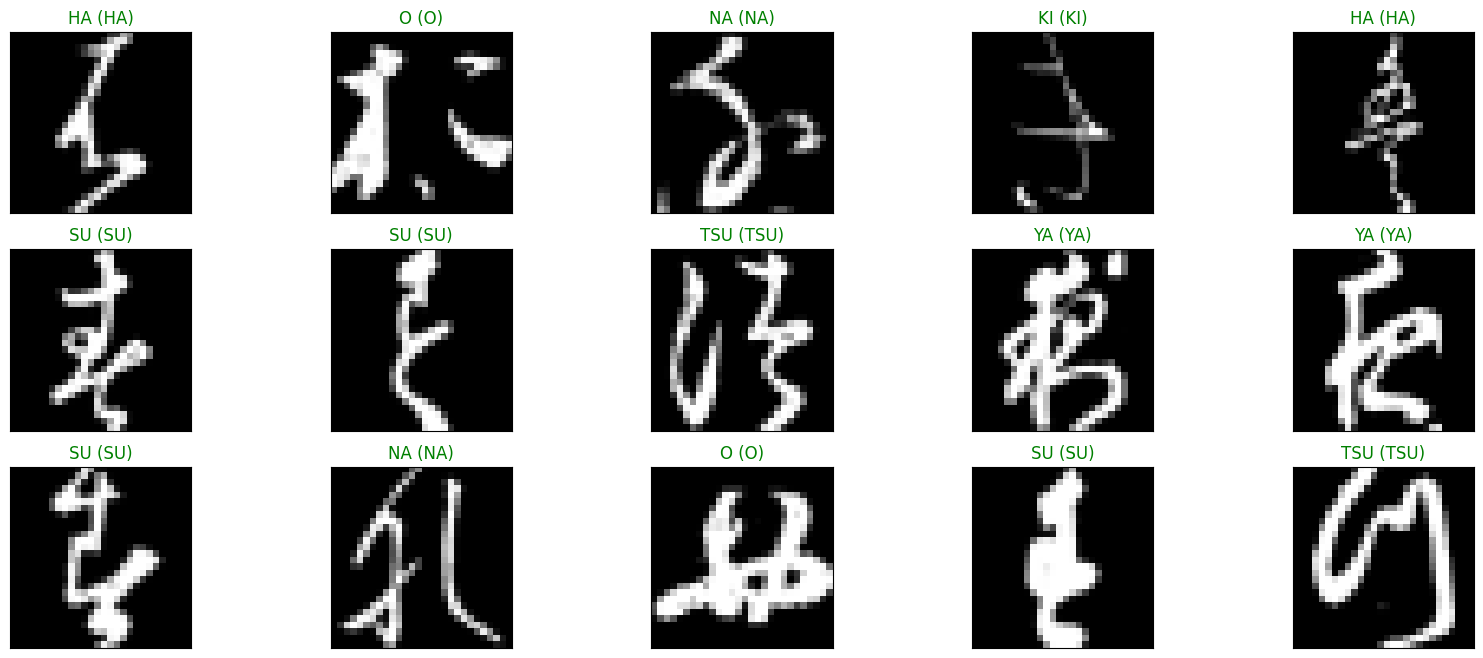

In [ ]:
y_tilde = model.predict(x_test_prep)

# Plot a random sample of 10 test images, their predicted labels and ground truth
figure = plt.figure(figsize=(20, 8))
for i, index in enumerate(np.random.choice(x_test_prep.shape[0], size=15, replace=False)):
    ax = figure.add_subplot(3, 5, i + 1, xticks=[], yticks=[])
    # Display each image
    ax.imshow(np.squeeze(x_test_prep[index]), cmap='gray')
    predict_index = np.argmax(y_tilde[index])
    true_index = np.argmax(y_test[index])
    # Set the title for each image
    ax.set_title("{} ({})".format(k_mnist_labels[predict_index],
                                  k_mnist_labels[true_index]),
                                  color=("green" if predict_index == true_index else "red"))